In [ ]:
!pip install tensorflow_addons
# !pip install wandb

In [ ]:
!pip install import_ipynb

In [ ]:
# import wandb
# from wandb.keras import WandbCallback

# wandb.init(project="CycleGAN")

In [ ]:
import os
import math
import numpy as np
from matplotlib import pyplot as plt
import tifffile as tiff
import re
import zipfile
import scipy.io
import random
from tifffile import imread
import argparse
import json
import pickle as pkl
import imageio
import itertools
import jsonschema
import keras
import pathlib
from tensorflow.image import ssim as ssim2
from tensorflow.image import ssim_multiscale as msssim
from tqdm.utils import IS_WIN
from tqdm.keras import TqdmCallback as _TqdmCallback
import functools
import warnings
import tqdm
import keras.backend as K
import tensorflow as tf
import collections
from importlib import import_module
from tensorflow import __version__ as _tf_version
from tensorflow.python.client.device_lib import list_local_devices
from packaging import version
from keras.utils.conv_utils import normalize_tuple
import tensorflow_probability as tfp
import fractions
import numexpr
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import constant_op
import skimage
import scipy

In [ ]:
# Open drive dynamically; prefer drives that have 'drive' in their name.
MAIN_DIR= r"/objective_transfer/deep_learning"
from google.colab import drive
drive.mount('/content/drive')
os.chdir(MAIN_DIR+'/CAREstd/')
import import_ipynb
from CARE_util import *

Mounted at /content/drive
importing Jupyter notebook from CARE_util.ipynb


In [ ]:


import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# autotune = tf.data.AUTOTUNE


"""
## Prepare the dataset
In this example, we will be using the
[horse to zebra](https://www.tensorflow.org/datasets/catalog/cycle_gan#cycle_ganhorse2zebra)
dataset.
"""
PATCH_SIZE = 256

# Define the standard image size.
# orig_img_size = (512, 512,1)
# Size of the random crops to be used during training.
input_img_size = (PATCH_SIZE, PATCH_SIZE,1)
# Weights initializer for the layers.
# kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
kernel_init = "glorot_uniform"
# Gamma initializer for instance normalization.
# gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_init = "glorot_uniform"

# HELPER FUNCTIONS
def revert_img(img,original_size, patch_shape, slide):
  # reverts original image and removes overlaps by splitting overlap over 2 images
  step = int(patch_shape-slide)
  reconstructed_arr = np.zeros((original_size,original_size))
  for x in range(img.shape[0]):
    for y in range(img.shape[1]):
      start_x = int(slide/2)
      start_y = int(slide/2)
      end_x = 0
      end_y = 0
      if x == 0:
        start_x = 0
        end_x = int(slide/2)
      if y == 0:
        start_y = 0
        end_y = int(slide/2)
      if x == img.shape[0]-1: end_x = int(slide/2)
      if y == img.shape[1]-1: end_y = int(slide/2)
      x_pos, y_pos = x * step + start_x, y * step + start_y
      reconstructed_arr[x_pos : x_pos + step + end_x, y_pos : y_pos + step + end_y] = img[x, y, start_x:start_x+step+end_x, start_y:start_y+step+end_y]
  return reconstructed_arr

def merge_patches(img, original_size, patch_shape, slide):
  #  merging patches, img is a 3D array of stacked patches
  row_len = int(math.sqrt(img.shape[0]))
  patches = np.zeros((row_len,row_len,patch_shape,patch_shape))
  for r in range(row_len):
      patches[r,:,:,:] = img[r*row_len:r*row_len+row_len,:,:]
  return revert_img(patches,original_size,patch_shape, slide)


# Metrics and losses

def psnr(y_true, y_pred):
    '''
    Computs the peak signal-to-noise ratio between two images. Note that the
    maximum signal value is assumed to be 1.
    '''
    psnr2 = tf.image.psnr(y_true, y_pred, max_val=1.0)
    return psnr2

# our ssim config
def ssim(y_true, y_pred):
    return ssim2(y_true, y_pred, 1, filter_size=3, filter_sigma=0.5, k2=0.05)

w = (0.0448, 0.2856, 0.3001, 0.2363, 0.1333)
def mssim(y_true, y_pred):
   return tf.image.ssim_multiscale(y_true, y_pred, 1, filter_size=11,power_factors=w, filter_sigma=1.5, k2=0.05)


def mse(img1, img2):
  # comparing one processed and preprocessed image
  squared_diff = (img1 -img2) ** 2
  summed = np.sum(squared_diff)
  num_pix = img1.shape[0] * img1.shape[1] #img1 and 2 should have same shape
  err = summed / num_pix
  return err

In [ ]:
# Modules
from keras.layers import Dense
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.core import Flatten
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import add


# Residual block
def res_block_gen(model, kernal_size, filters, strides):

    gen = model

    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    # Using Parametric ReLU
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)

    model = add([gen, model])

    return model


def up_sampling_block(model, kernal_size, filters, strides):

    # In place of Conv2D and UpSampling2D we can also use Conv2DTranspose (Both are used for Deconvolution)
    # Even we can have our own function for deconvolution (i.e one made in Utils.py)
    #model = Conv2DTranspose(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = UpSampling2D(size = 2)(model)
    model = LeakyReLU(alpha = 0.2)(model)

    return model


def discriminator_block(model, filters, kernel_size, strides):

    model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = LeakyReLU(alpha = 0.2)(model)

    return model

# Network Architecture is same as given in Paper https://arxiv.org/pdf/1609.04802.pdf
class Generator(object):

    def __init__(self, noise_shape):

        self.noise_shape = noise_shape

    def generator(self):

	    gen_input = Input(shape = self.noise_shape)

	    model = Conv2D(filters = 64, kernel_size = 9, strides = 1, padding = "same")(gen_input)
	    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)

	    gen_model = model

        # Using 16 Residual Blocks
	    for index in range(16):
	        model = res_block_gen(model, 3, 64, 1)

	    model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(model)
	    model = BatchNormalization(momentum = 0.5)(model)
	    model = add([gen_model, model])

	    # Using 2 UpSampling Blocks
	    for index in range(2):
	        model = up_sampling_block(model, 3, 256, 1)

	    model = Conv2D(filters = 3, kernel_size = 9, strides = 1, padding = "same")(model)
	    model = Activation('tanh')(model)

	    generator_model = Model(inputs = gen_input, outputs = model)

	    return generator_model

# Network Architecture is same as given in Paper https://arxiv.org/pdf/1609.04802.pdf
class Discriminator(object):

    def __init__(self, image_shape):

        self.image_shape = image_shape

    def discriminator(self):

        dis_input = Input(shape = self.image_shape)

        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(dis_input)
        model = LeakyReLU(alpha = 0.2)(model)

        model = discriminator_block(model, 64, 3, 2)
        model = discriminator_block(model, 128, 3, 1)
        model = discriminator_block(model, 128, 3, 2)
        model = discriminator_block(model, 256, 3, 1)
        model = discriminator_block(model, 256, 3, 2)
        model = discriminator_block(model, 512, 3, 1)
        model = discriminator_block(model, 512, 3, 2)

        model = Flatten()(model)
        model = Dense(1024)(model)
        model = LeakyReLU(alpha = 0.2)(model)

        model = Dense(1)(model)
        model = Activation('sigmoid')(model)

        discriminator_model = Model(inputs = dis_input, outputs = model)

        return discriminator_model



In [ ]:
# add arbitrary channel dimension and augments data on flow, also splits data into batches
class DataGenerator:
    '''
    Generates batches of image pairs with real-time data augmentation.
    Parameters
    ----------
    shape: tuple of int
        Shape of batch images (excluding the channel dimension).
    batch_size: int
        Batch size.
    transform_function: str or callable or None
        Function used for data augmentation. Typically you will set
        ``transform_function='rotate_and_flip'`` to apply combination of
        randomly selected image rotation and flipping.  Alternatively, you can
        specify an arbitrary transformation function which takes two input
        images (source and target) and returns transformed images. If
        ``transform_function=None``, no augmentation will be performed.
    intensity_threshold: float
        If ``intensity_threshold > 0``, pixels whose intensities are greater
        than this threshold will be considered as foreground.
    area_ratio_threshold: float between 0 and 1
        If ``intensity_threshold > 0``, the generator calculates the ratio of
        foreground pixels in a target patch, and rejects the patch if the ratio
        is smaller than this threshold.
    scale_factor: int != 0
        Scale factor for the target patch size. Positive and negative values
        mean up- and down-scaling respectively.
    '''
    def __init__(self,
                 shape,
                 batch_size,
                 transform_function='rotate_and_flip',
                 intensity_threshold=0.0,
                 area_ratio_threshold=0.0,
                 scale_factor=1):
        def rotate_and_flip(x, y, dim):
            if dim == 2:
                k = np.random.randint(0, 4)
                x, y = [np.rot90(v, k=k) for v in (x, y)]
                if np.random.random() < 0.5:
                    x, y = [np.fliplr(v) for v in (x, y)]
                if np.random.random() < 0.5:
                    deg = np.random.randint(0, high=25)
                    x, y = [scipy.ndimage.interpolation.rotate(v, deg, axes=(1, 0), reshape=False, order=3, mode='constant', cval=0.0) for v in (x,y)]
                return x, y
            else:
                raise ValueError('Unsupported dimension')

        self._shape = tuple(shape)
        self._batch_size = batch_size

        dim = len(self._shape)

        if transform_function == 'rotate_and_flip':
            if shape[-2] != shape[-1]:
                raise ValueError(
                    'Patch shape must be square when using `rotate_and_flip`; '
                    f'Received shape: {shape}')
            self._transform_function = lambda x, y: rotate_and_flip(x, y, dim)
        elif callable(transform_function):
            self._transform_function = transform_function
        elif transform_function is None:
            self._transform_function = lambda x, y: (x, y)
        else:
            raise ValueError('Invalid transform function')

        self._intensity_threshold = intensity_threshold

        if not 0 <= area_ratio_threshold <= 1:
            raise ValueError('"area_ratio_threshold" must be between 0 and 1')
        self._area_threshold = area_ratio_threshold * np.prod(shape)

        self._scale_factor = normalize_tuple(scale_factor, dim, 'scale_factor')
        if any(not isinstance(f, int) or f == 0 for f in self._scale_factor):
            raise ValueError('"scale_factor" must be nonzero integer')

    class _Sequence(tf.keras.utils.Sequence):
        def _scale(self, shape):
            return tuple(
                s * f if f > 0 else s // -f
                for s, f in zip(shape, self._scale_factor))

        def __init__(self,
                     x,
                     y,
                     batch_size,
                     shape,
                     transform_function,
                     intensity_threshold,
                     area_threshold,
                     scale_factor):
            self._batch_size = batch_size
            self._transform_function = transform_function
            self._intensity_threshold = intensity_threshold
            self._area_threshold = area_threshold
            self._scale_factor = scale_factor

            for s, f, in zip(shape, self._scale_factor):
                if f < 0 and s % -f != 0:
                    raise ValueError(
                        'When downsampling, all elements in `shape` must be '
                        'divisible by the scale factor; '
                        f'Received shape: {shape}, '
                        f'scale factor: {self._scale_factor}')

            self._x, self._y = [
                list(m) if isinstance(m, (list, tuple)) else [m]
                for m in [x, y]]
            self._x = np.moveaxis(self._x,0,-1)
            self._y = np.moveaxis(self._y,0,-1)
            if len(self._x) != len(self._y):
                raise ValueError(
                    'Different number of images are given: '
                    f'{len(self._x)} vs. {len(self._y)}')

            if len({m.dtype for m in self._x}) != 1:
                raise ValueError('All source images must be the same type')
            if len({m.dtype for m in self._y}) != 1:
                raise ValueError('All target images must be the same type')
            for i in range(len(self._x)):
                if len(self._x[i].shape) == len(shape):
                    self._x[i] = self._x[i][..., np.newaxis]

                if len(self._y[i].shape) == len(shape):
                    self._y[i] = self._y[i][..., np.newaxis]

                if len(self._x[i].shape) != len(shape) + 1:
                    raise ValueError(f'Source image must be {len(shape)}D')

                if len(self._y[i].shape) != len(shape) + 1:
                    raise ValueError(f'Target image must be {len(shape)}D')
                if self._x[i].shape[:-1] < shape:
                    raise ValueError(
                        'Source image must be larger than the patch size')

                expected_y_image_size = self._scale(self._x[i].shape[:-1])
                if self._y[i].shape[:-1] != expected_y_image_size:
                    raise ValueError('Invalid target image size: '
                                     f'expected {expected_y_image_size}, '
                                     f'but received {self._y[i].shape[:-1]}')

            if len({m.shape[-1] for m in self._x}) != 1:
                raise ValueError(
                    'All source images must have the same number of channels')
            if len({m.shape[-1] for m in self._y}) != 1:
                raise ValueError(
                    'All target images must have the same number of channels')
            self._batch_x = np.zeros(
                (batch_size, *shape, self._x[0].shape[-1]),
                dtype=self._x[0].dtype)
            self._batch_y = np.zeros(
                (batch_size, *self._scale(shape),self._y[0].shape[-1]),
                dtype=self._y[0].dtype)

        def __len__(self):
            return len(self._x) // self._batch_size # return a dummy value

        def __next__(self):
            return self.__getitem__(0)

        def __getitem__(self, _):
            for i in range(self._batch_size):
                for _ in range(139):
                    j = np.random.randint(0, len(self._x))

                    tl = [np.random.randint(0, a - b + 1)
                          for a, b in zip(
                              self._x[j].shape, self._batch_x.shape[1:])]

                    x = np.copy(self._x[j][tuple(
                        [slice(a, a + b) for a, b in zip(
                            tl, self._batch_x.shape[1:])])])
                    y = np.copy(self._y[j][tuple(
                        [slice(a, a + b) for a, b in zip(
                            self._scale(tl), self._batch_y.shape[1:])])])

                    if (self._intensity_threshold <= 0.0 or
                            np.count_nonzero(y > self._intensity_threshold)
                            >= self._area_threshold):
                        break
                else:
                    import warnings
                    warnings.warn(
                        'Failed to sample a valid patch',
                        RuntimeWarning,
                        stacklevel=3)


                self._batch_x[i], self._batch_y[i] = \
                    self._transform_function(x, y)
            return self._batch_x, self._batch_y

    def flow(self, x, y):
        '''
        Returns a `keras.utils.Sequence` object which generates batches
        infinitely. It can be used as an input generator for
        `keras.models.Model.fit_generator()`.
        Parameters
        ----------
        x: array_like or list of array_like
            Source image(s).
        y: array_like or list of array_like
            Target image(s).
        Returns
        -------
        keras.utils.Sequence
            `keras.utils.Sequence` object which generates tuples of source and
            target image patches.
        '''
        return self._Sequence(x,
                              y,
                              self._batch_size,
                              self._shape,
                              self._transform_function,
                              self._intensity_threshold,
                              self._area_threshold,
                              self._scale_factor)


def expandLastDim(data):
    return np.expand_dims(data, -1)

def create_patches(img, patch_shape, slide):
    # returns stack of patches and number of patches
    patch_img = skimage.util.view_as_windows(img, (patch_shape,patch_shape), step=patch_shape-slide)
    patch = patch_img.reshape(patch_img.shape[0]*patch_img.shape[1],patch_shape,patch_shape) # more time efficient
    return patch

def patchify(input, patch_shape, slide):
    # getting number of input images
    len_to_allocate = int(np.shape(input)[0]*((slide-np.shape(input)[1]) / (slide-patch_shape))**2)
    data = np.zeros((len_to_allocate,patch_shape,patch_shape))
    count = 0
    for i in range(np.shape(input)[0]):
      A = create_patches(input[i], patch_shape, slide)
      data[count:count+len(A),:,:] = A[:,:,:]
      count = count + len(A)
    print("      [PATCHIFYING COMPLETED] output shape, slide: ",np.shape(data),slide,"; number of images: ", np.shape(input)[0], ", number of patches: ", np.shape(data)[0])
    return data

def load_data(path, expand=False, patch=None, slide='half', shuffle=False):
    # Loading preprocessed image patches and adding 4th arbitrary dimension
    b = np.load(path)
    training_data = b['t']
    val_data = b['v']

    # patchify if patch size is passed
    if patch != None:
      if slide=='half':
        slide = int(patch/2)
      else: slide = 0
      training_data = patchify(training_data, patch, slide)
      val_data = patchify(val_data, patch, slide)

    # if len(np.shape(training_data))>3:
    #   # for 3D only, changing dimensions
    #   training_data = np.transpose(training_data, (0, 3, 1, 2,4))
    #   val_data = np.transpose(val_data, (0, 3, 1, 2,4))
    if shuffle == True:
      training_data = np.random.shuffle(training_data)
      val_data = np.random.shuffle(val_data)
    if expand == True:
      training_data = expandLastDim(training_data)
      val_data = expandLastDim(val_data)

    return [training_data, val_data ]



## **Execution**

In [ ]:
def config(patch_size, depth):
  return {
      'img_size': 512,
      'learning_rate': 1e-4,
      'batch_size': 16,
      'alpha': 0.6,
      'patch_size':patch_size,
      'input_shape': [patch_size, patch_size],
      'kern_size':3,
      'kern_sigma': 0.99,
      'n_depth': depth,
      'first_depth': 32,
      'dropout': 0,
      'epoch':200,
      'lr_decay_factor':0.99,
      'lr_decay_patience':5,
  }

def genSSIML1_loss(alpha=0.84):
  # this loss takes in 2D patch of dimension (n,n,3) and calculate loss on middle patch only
  def SSIM_L1_loss(y_true, y_pred):
    ssim_partial = 1-((mssim(y_true, y_pred)+1)*0.5)
    mae_partial = tf.keras.losses.mae(
          *[tf.keras.backend.batch_flatten(y) for y in [y_true, y_pred]])

    # # adding l2 regulizer
    # l2_norms = [tf.nn.l2_loss(v) for v in model.trainable_variables]
    # l2_norm = tf.reduce_sum(l2_norms)
    # lambda_ = 0.1
    return alpha*ssim_partial  + (1-alpha)*mae_partial
  return SSIM_L1_loss

def genSSIMVar_loss(alpha=0.84):
  # this loss takes in 2D patch of dimension (n,n,3) and calculate loss on middle patch only
  def SSIMVar_loss(y_true, y_pred):
    SSIM = 1-((mssim(y_true, y_pred)+1)*0.5)
    MAE = tf.keras.losses.mae(
          *[tf.keras.backend.batch_flatten(y) for y in [mov_var(y_true), mov_var(y_pred)]])
    return alpha * SSIM + (1-alpha) * MAE
  return SSIMVar_loss

# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

def generator_loss_fn(fake):
  fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
  return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

In [ ]:
def normalize_between_zero_and_one(m):
    max_val, min_val = m.max(), m.min()
    diff = max_val - min_val
    return (m - min_val) / diff if diff > 0 else np.zeros_like(m)

"""
## Create a callback that periodically saves generated images
"""


class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""
    # changed to computing SSIM
    def __init__(self, val_set, img_size = 512, patch_shape=128, slide=64):
        # input: val_set = [x_val, y_val]
        print("init: ", np.shape(val_set[0]))
        self.x_val = val_set[0]
        self.y_val = val_set[1]
        self.img_size = img_size
        self.patch_shape = patch_shape
        self.slide = slide

    def on_epoch_end(self, epoch, logs=None):
        print("")
        # computing metrics of each patch
        val_ssim = []
        val_psnr = []
        val_mse = []
        # for i in range(len(self.x_val)):
        # curr = np.expand_dims(self.x_val[i],-1)
        # self.model.gen_G.summary()
        prediction = self.model.gen_G(self.x_val).numpy()
        for i in range(len(self.x_val)):
          val_ssim.append(ssim(tf.convert_to_tensor([self.y_val[i,...],],dtype=tf.float32) ,tf.convert_to_tensor([prediction[i,...],],dtype=tf.float32)))
          val_psnr.append(psnr(tf.convert_to_tensor([self.y_val[i,...],],dtype=tf.float32) ,tf.convert_to_tensor([prediction[i,...],],dtype=tf.float32)))
          val_mse.append(mse(self.y_val[i,...],[prediction[i,...],]))
        average_val_ssim = np.average(val_ssim)
        average_val_psnr = np.average(val_psnr)
        average_val_mse = np.average(val_mse)

        # prediction = self.model.gen_G(self.x_val[:number]).numpy()
        # x_merge = np.expand_dims(merge_patches(self.x_val[:number,...,0], self.img_size , self.patch_shape, self.slide), axis=-1)
        # p_merge = np.expand_dims(merge_patches(prediction[:number,...,0], self.img_size , self.patch_shape, self.slide), axis=-1)
        # y_merge = np.expand_dims(merge_patches(self.y_val[:number,...,0], self.img_size , self.patch_shape, self.slide), axis=-1)
        # val_merged_ssim = ssim(tf.convert_to_tensor([y_merge,],dtype=tf.float32) ,tf.convert_to_tensor([p_merge,],dtype=tf.float32)).numpy()
        # val_merged_psnr = psnr(tf.convert_to_tensor([y_merge,],dtype=tf.float32) ,tf.convert_to_tensor([p_merge,],dtype=tf.float32)).numpy()
        # va_merged_mse = mse(y_merge,x_merge)
        print("Epoch: "+str(epoch)+"| VALIDATION | average_val_ssim: "+str(average_val_ssim)+" | average_val_psnr: "+str(average_val_psnr) +" | average_val_mse: "+str(average_val_mse))
        result = [self.x_val[0,...,0], prediction[0,...,0],self.y_val[0,...,0]]
        result = [normalize_between_zero_and_one(m) for m in result]
        # plot and saving merged images
        _, ax = plt.subplots(1, 3, figsize=(30,30))
        ax[0].imshow(result[0])
        ax[1].imshow(result[1])
        ax[2].imshow(result[2])
        ax[0].set_title("Input image")
        ax[1].set_title("Translated image")
        ax[2].set_title("GT image")
        ax[0].axis("off")
        ax[1].axis("off")
        ax[2].axis("off")
        plt.show()
        plt.savefig("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1))


In [ ]:
#################################################################################
''' Data was Normalized in Local Prep'''

model_name = 'CycleGAN_original_keras_0108'
main_path = MAIN_DIR

if not os.path.exists(os.path.join(main_path,model_name)): os.mkdir(os.path.join(main_path,model_name))
model_save_path = os.path.join(main_path,model_name)
os.chdir(MAIN_DIR)
(X,X_val) = load_data(MAIN_DIR+'/npz/Cervix_all_data_original.npz', expand=False, patch=PATCH_SIZE, slide=None, shuffle=False)
(Y,Y_val) = load_data(MAIN_DIR+'/npz/Cervix_all_data_labels_original.npz', expand=False, patch=PATCH_SIZE, slide=None, shuffle=False)
training_data = np.copy(X)
training_data_labels = np.copy(Y)
# shuffling training set, data and labels separatedly
np.random.shuffle(X)
np.random.shuffle(Y)
print(np.shape(X))

      [PATCHIFYING COMPLETED] output shape, slide:  (952, 256, 256) 0 ; number of images:  238 , number of patches:  952
      [PATCHIFYING COMPLETED] output shape, slide:  (136, 256, 256) 0 ; number of images:  34 , number of patches:  136
      [PATCHIFYING COMPLETED] output shape, slide:  (952, 256, 256) 0 ; number of images:  238 , number of patches:  952
      [PATCHIFYING COMPLETED] output shape, slide:  (136, 256, 256) 0 ; number of images:  34 , number of patches:  136
(952, 256, 256)


## **Train GAN**

In [ ]:
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

In [ ]:
# cycle_gan_model = keras.models.load_model('./model_checkpoints/cyclegan_full',compile=False)

In [ ]:
# # Create cycle gan model
# wandb.config = {
#   "learning_rate": 1e-4,
#   "epochs": 10,
#   "batch_size": 16,
#   "loss_gen": generator_loss_fn,
#   "loss_disc": discriminator_loss_fn,
# }



# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
    metrics = [{'psnr': psnr, 'ssim': ssim}]
)


In [ ]:
config_train = {
      'img_size': 512,
      'learning_rate': 1e-4,
      'batch_size': 4,
      'patch_size':PATCH_SIZE,
      'input_shape': [PATCH_SIZE, PATCH_SIZE],
      'epoch':100,
      'lr_decay_factor':0.99,
      'lr_decay_patience':5,
  }

In [ ]:
data_gen = DataGenerator(
    config_train['input_shape'],
    config_train['batch_size'],
    transform_function=None)
    # transform_function='rotate_and_flip')
tdata = data_gen.flow(*list(zip([X,Y])))

# Callbacks
plotter = GANMonitor([expandLastDim(X_val), expandLastDim(Y_val)], img_size = 512, patch_shape=PATCH_SIZE, slide=0)
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="test",
    monitor='G_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    save_freq='epoch',)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='G_loss',verbose=True,factor=0.9,min_delta=0,patience=5)


init:  (136, 256, 256, 1)


Epoch 1/50
238/238 [==============================] - ETA: 0s - G_loss: 2.3378 - F_loss: 2.4473 - D_X_loss: 0.2371 - D_Y_loss: 0.2543
Epoch: 0| VALIDATION | average_val_ssim: 0.23067401 | average_val_psnr: 15.162425 | average_val_mse: 0.030639844509845277


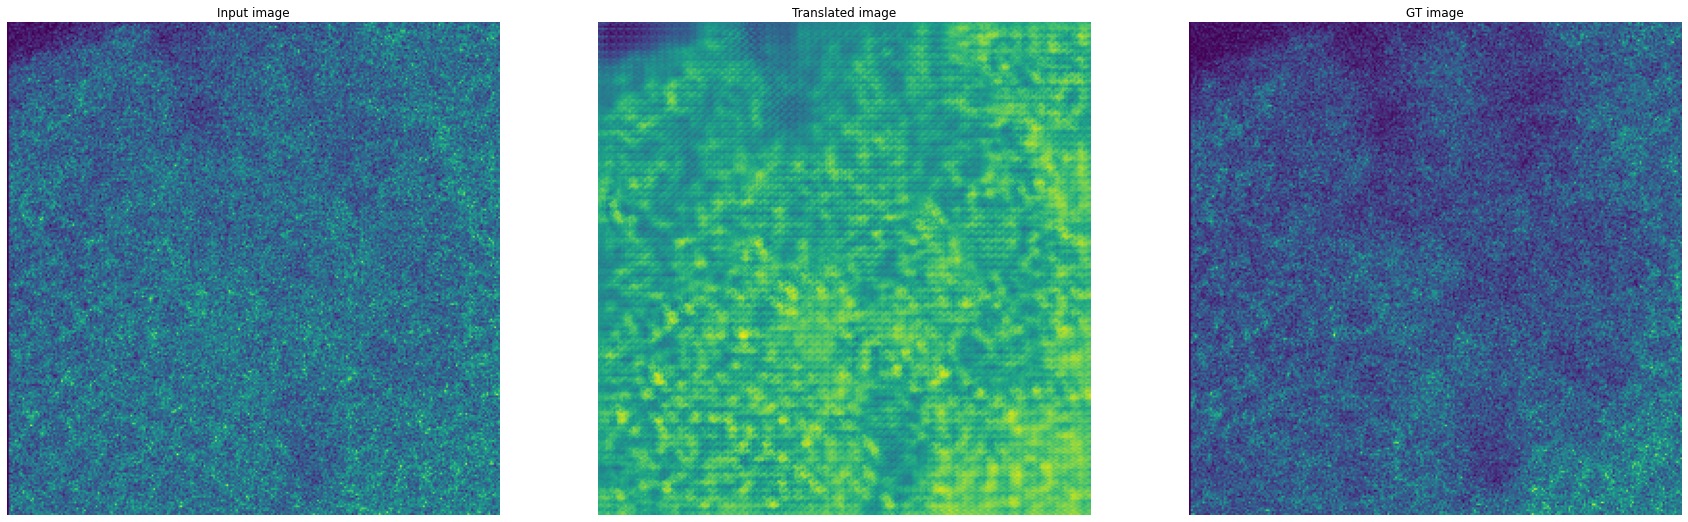


Epoch 1: G_loss improved from -inf to 1.88955, saving model to test
238/238 [==============================] - 399s 1s/step - G_loss: 2.3360 - F_loss: 2.4460 - D_X_loss: 0.2367 - D_Y_loss: 0.2541 - lr: 0.0010
Epoch 2/50
238/238 [==============================] - ETA: 0s - G_loss: 1.9602 - F_loss: 2.0382 - D_X_loss: 0.2029 - D_Y_loss: 0.1894
Epoch: 1| VALIDATION | average_val_ssim: 0.19369479 | average_val_psnr: 14.438287 | average_val_mse: 0.036202757804493405


<Figure size 432x288 with 0 Axes>

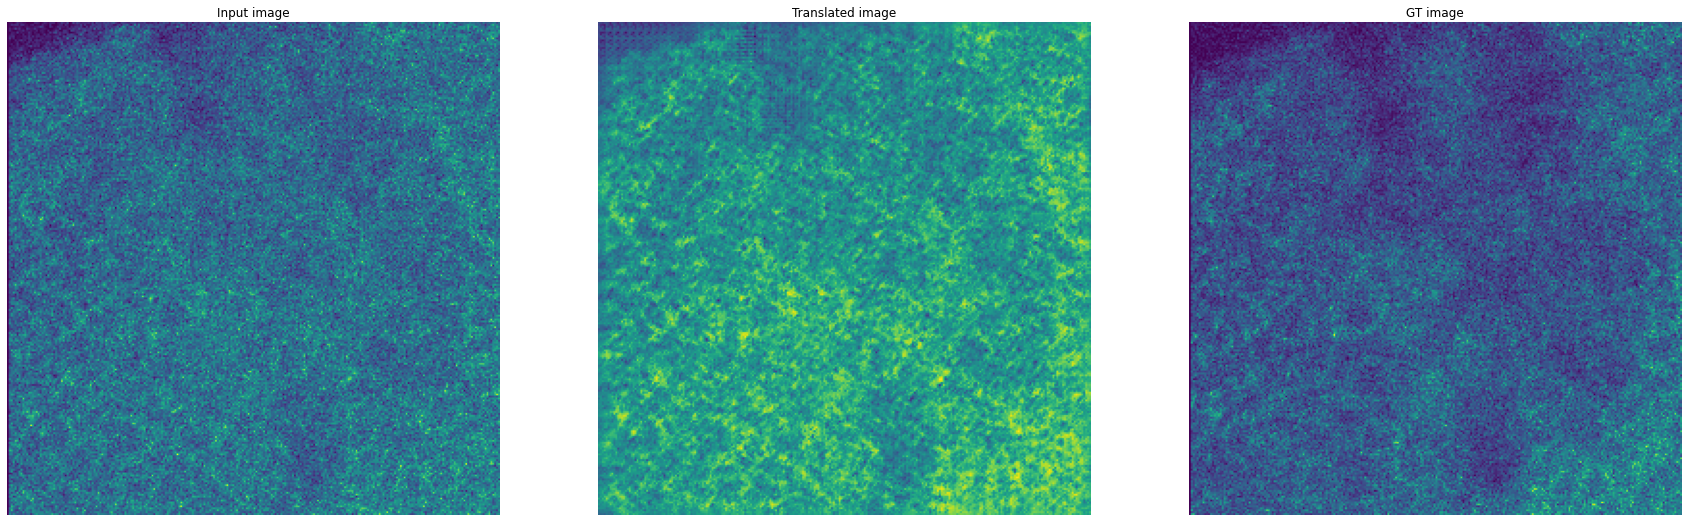


Epoch 2: G_loss improved from 1.88955 to 1.92881, saving model to test

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
238/238 [==============================] - 340s 1s/step - G_loss: 1.9601 - F_loss: 2.0382 - D_X_loss: 0.2028 - D_Y_loss: 0.1896 - lr: 0.0010
Epoch 3/50
238/238 [==============================] - ETA: 0s - G_loss: 1.7723 - F_loss: 1.7413 - D_X_loss: 0.2443 - D_Y_loss: 0.2310
Epoch: 2| VALIDATION | average_val_ssim: 0.1696176 | average_val_psnr: 13.855923 | average_val_mse: 0.04154547993525634


<Figure size 432x288 with 0 Axes>

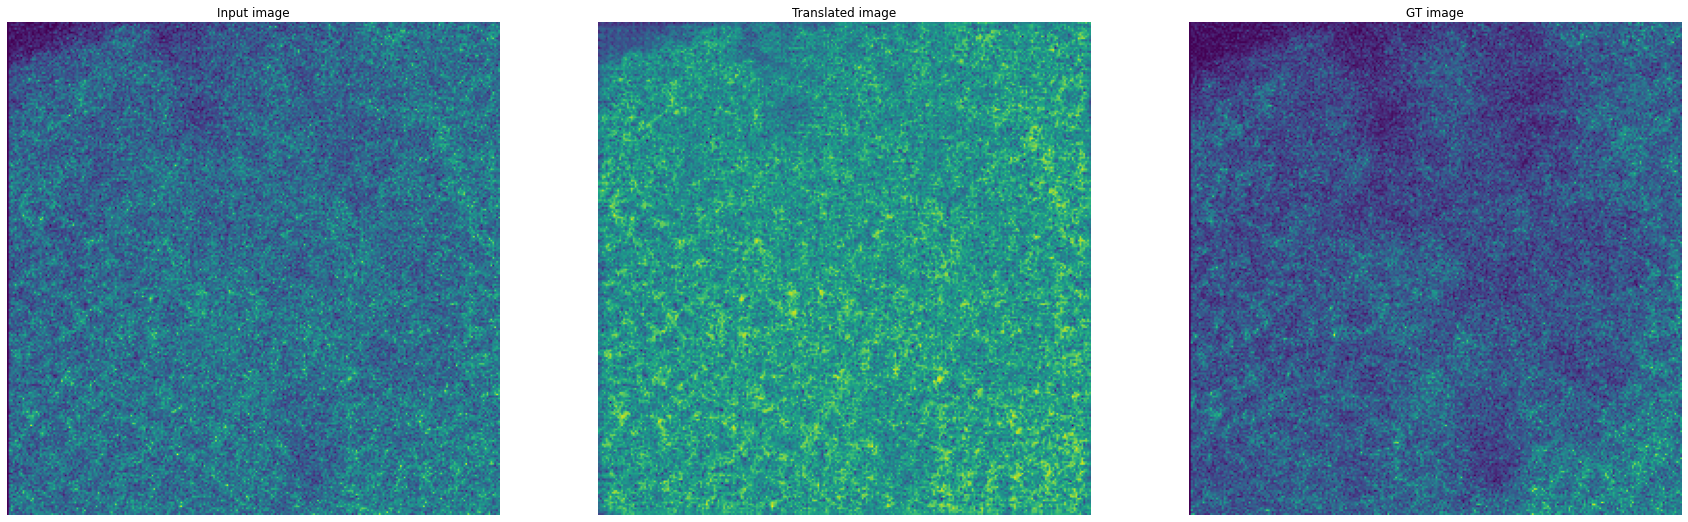


Epoch 3: G_loss did not improve from 1.92881
238/238 [==============================] - 339s 1s/step - G_loss: 1.7722 - F_loss: 1.7399 - D_X_loss: 0.2443 - D_Y_loss: 0.2311 - lr: 9.0000e-04
Epoch 4/50
238/238 [==============================] - ETA: 0s - G_loss: 1.4460 - F_loss: 1.4406 - D_X_loss: 0.2494 - D_Y_loss: 0.2546
Epoch: 3| VALIDATION | average_val_ssim: 0.16043715 | average_val_psnr: 13.453556 | average_val_mse: 0.04562169098712225


<Figure size 432x288 with 0 Axes>

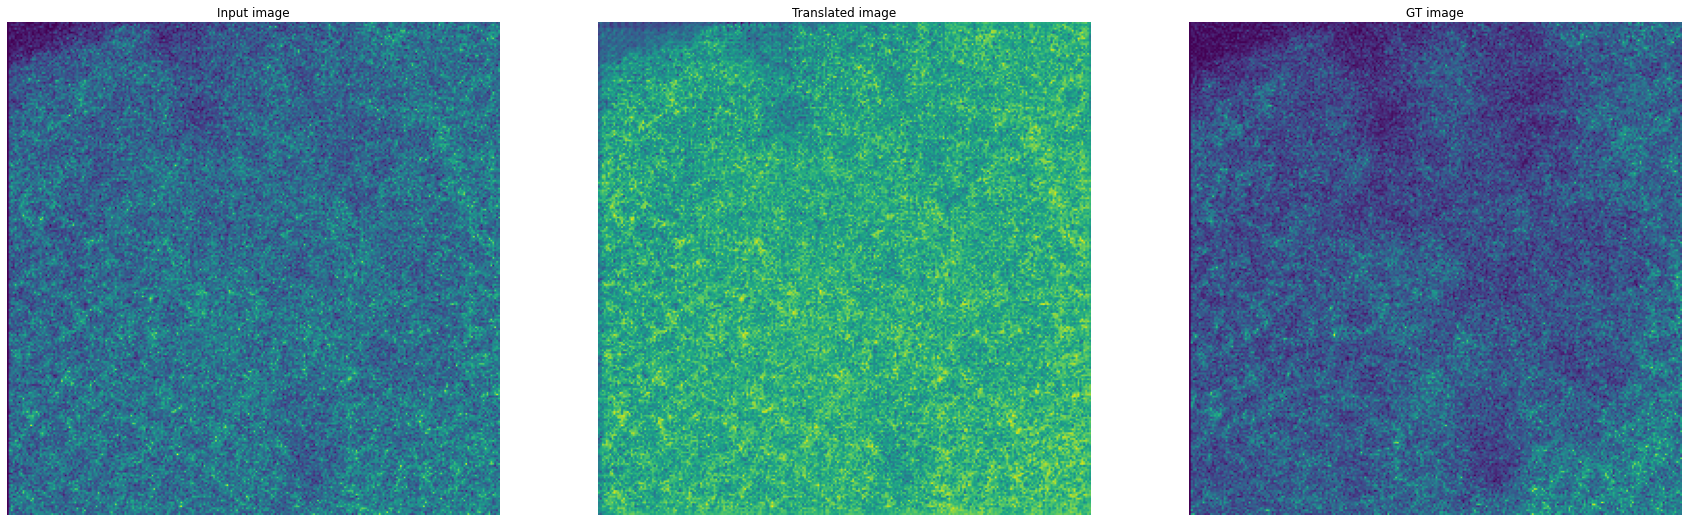


Epoch 4: G_loss did not improve from 1.92881
238/238 [==============================] - 336s 1s/step - G_loss: 1.4460 - F_loss: 1.4399 - D_X_loss: 0.2494 - D_Y_loss: 0.2547 - lr: 9.0000e-04
Epoch 5/50
 84/238 [=========>....................] - ETA: 3:15 - G_loss: 1.2897 - F_loss: 1.3140 - D_X_loss: 0.2457 - D_Y_loss: 0.2498

In [ ]:
# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
cycle_gan_model.fit(
    x=tdata,
    epochs=50,
    callbacks=[plotter, model_checkpoint_callback, lr_callback],
)

In [ ]:
def normalize(img):
  # Normalizing images between 0 and 1 and preserving distribution
  img_norm = (img - np.amin(img))/( np.amax(img)- np.amin(img))
  return img_norm

In [ ]:
x_val = expandLastDim((X_val))
print(np.shape(x_val))
y_val = expandLastDim((Y_val))
img_size = 512
patch_shape = PATCH_SIZE
slide = 0
start = 80
end = start+ int((img_size-slide)/(patch_shape-slide))**2

prediction = cycle_gan_model.gen_F(x_val[start:end]).numpy()
x_merge = np.expand_dims(normalize(merge_patches(x_val[start:end,...,0], img_size , patch_shape, slide)), axis=-1)
print(np.shape(x_merge))
p_merge = np.expand_dims(normalize(merge_patches(prediction[0:end-start,...,0], img_size , patch_shape, slide)), axis=-1)
y_merge = np.expand_dims(normalize(merge_patches(y_val[start:end,...,0], img_size , patch_shape, slide)), axis=-1)
val_merged_ssim = ssim(tf.convert_to_tensor([y_merge,],dtype=tf.float32) ,tf.convert_to_tensor([p_merge,],dtype=tf.float32)).numpy()
val_merged_psnr = psnr(tf.convert_to_tensor([y_merge,],dtype=tf.float32) ,tf.convert_to_tensor([p_merge,],dtype=tf.float32)).numpy()
va_merged_mse = mse(y_merge,x_merge)
print("| VALIDATION | val_merged_ssim: "+str(val_merged_ssim)+" | val_merged_psnr: "+str(val_merged_psnr)+" | va_merged_mse: "+str(va_merged_mse))

# plot and saving merged images
_, ax = plt.subplots(1, 3, figsize=(30,30))
ax[0].imshow(x_merge[...,0])
ax[1].imshow(p_merge[...,0])
ax[2].imshow(y_merge[...,0])
ax[0].set_title("Input image")
ax[1].set_title("Translated image")
ax[2].set_title("GT image")
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")


In [ ]:
print(np.shape(prediction))

In [ ]:
print(np.mean(p_merge))

In [ ]:
cycle_gan_model.save('./model_checkpoints/cyclegan_full')

##**Testing**

In [ ]:



def plot(img, label, hist=False, size=(10,10)):
  plt.figure(figsize = size)
  if hist==True:
    plt.hist(img.flatten(), bins=120)
  else: plt.imshow(img,cmap="gray")
  plt.title(label)

def normalize_percentile(img, pmin=0.1, pmax=99.9, clip = True):
  eps=1e-20 # avoid zero division
  mi = np.percentile(img,pmin,axis=None,keepdims=True)
  # mi = np.amin(img)
  # print("mi",mi)
  ma = np.percentile(img,pmax,axis=None,keepdims=True)
  if clip == True: return np.clip((img - mi) / ( ma - mi + eps ), 0, 1)
  return (img - mi) / ( ma - mi + eps )

# def ssim(y_true, y_pred):
#     '''
#     Computes the structural similarity index between two images. Note that the
#     maximum signal value is assumed to be 1.
#     '''

#     return ssim2(y_true, y_pred,1,k2=0.05)
# our SSIM loss
from tensorflow.image import ssim as ssim2
def ssim_our(y_true, y_pred):
  return ssim2(y_true, y_pred,1,k2=0.05)

def _get_gaussian_kernel(dim, size, sigma):
    k = size // 2
    normal = tfp.distributions.Normal(0.0, sigma)
    p = normal.prob(tf.range(-k, size - k, dtype=tf.float32))

    indices = [chr(i) for i in range(105, 105 + dim)]
    eq = ','.join(indices) + '->' + ''.join(indices)
    kernel = tf.einsum(eq, *([p] * dim))
    kernel /= tf.reduce_sum(kernel)
    kernel = kernel[..., tf.newaxis, tf.newaxis]

    return kernel

# RCAN ssim
import keras.backend as K
def ssim_rcan(y_true, y_pred):
    '''
    Computes the structural similarity index between two images. Note that the
    maximum signal value is assumed to be 1.
    References
    ----------
    Image Quality Assessment: From Error Visibility to Structural Similarity
    https://doi.org/10.1109/TIP.2003.819861
    '''

    c1 = 0.01 ** 2
    c2 = 0.03 ** 2

    dim = K.ndim(y_pred) - 2
    if dim not in (2, 3):
        raise NotImplementedError(f'{dim}D SSIM is not suported')

    num_channels = K.int_shape(y_pred)[-1]

    kernel = _get_gaussian_kernel(dim, 11, 1.5)
    conv = K.conv2d if dim == 2 else K.conv3d

    def average(x):
        # channel-wise weighted average using the Gaussian kernel
        return tf.concat(
            [conv(y, kernel) for y in tf.split(x, num_channels, axis=-1)],
            axis=-1)

    ux = average(y_true)
    uy = average(y_pred)

    a = ux * uy
    b = K.square(ux) + K.square(uy)
    c = average(y_true * y_pred)
    d = average(K.square(y_true) + K.square(y_pred))

    lum = (2 * a + c1) / (b + c1)
    cs = (2 * (c - a) + c2) / (d - b + c2)

    return K.mean(K.batch_flatten(lum * cs), axis=-1)

def predictAndPlot(model,input,val, start, end, isPlot=True, merge=True, normalize=False, clip=False):
  pred = model.gen_G(input[start:end])
  print("shape of predicted image: ", np.shape(input))
  if len(np.shape(input)) > 3:
    if merge:
      result = [merge_patches(input[start:end,:,:,0],512,256,128), merge_patches(pred[start:end,:,:,0],512,256,128), merge_patches(val[start:end,:,:,0],512,256,128)]
    else: result = [input[start:end,:,:,0], pred[start:end,:,:,0],val[start:end,:,:,0]]
  else:
    if merge:
      result = [merge_patches(input[start:end,:,:],512,256,128), merge_patches(pred[start:end,:,:,0],512,256,128), merge_patches(val[start:end,:,:],512,256,128)]
    else: result = [input[start:end,:,:], pred[start:end,:,:,0], val[start:end,:,:]]
  if normalize: result = [normalize_percentile(m) for m in result]
  if clip: result = [np.clip(255 * m, 0, 255).astype('uint8') for m in result]
  res_img =  np.concatenate((np.concatenate((result[0],result[1]),axis=1),result[2]),axis=1)
  plot(res_img, "input, restored, gt", size=(30,30))
  # plot(result[0],'input 25x')
  # plot(result[1],'restored')
  # plot(result[2],'gt 40x')
  if isPlot:
    plot(result[0],'hist input 25x',hist=True)
    plot(result[1],'hist restored',hist=True)
    plot(result[2],'hist gt 40x',hist=True)
  return result

def evalSSIM(result):
  result1 = [np.expand_dims(m,-1) for m in result]
  raw = tf.convert_to_tensor(np.expand_dims(result1[0],0),dtype=np.float32)
  rest = tf.convert_to_tensor(np.expand_dims(result1[1],0),dtype=np.float32)
  gt = tf.convert_to_tensor(np.expand_dims(result1[2],0),dtype=np.float32)
  # Metric evaluation
  print('raw vs gt=======================')
  print("Our SSIM between raw and ground truth: ",ssim_our(gt,raw).numpy())
  print("RCAN paper SSIM between raw and ground truth: ",ssim_rcan(gt, raw).numpy())
  print('predicted vs gt=======================')
  print("Our SSIM between predicted and ground truth: ",ssim_our(gt, rest).numpy())
  print("RCAN paper SSIM between predicted and ground truth: ",ssim_rcan(gt,rest).numpy())
  print('predicted vs raw=======================')
  print("Our SSIM between predicted and raw: ",ssim_our(raw, rest).numpy())
  print("RCAN paper SSIM between predicted and raw: ",ssim_rcan(raw, rest).numpy())

In [ ]:
import tensorflow_probability as tfp
import math
result = predictAndPlot(cycle_gan_model,X_val, Y_val, 0, 9, isPlot=True, merge=True, normalize=False, clip=False)
evalSSIM(result)